In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import optuna
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# **1. Data loading**

In [60]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
df_submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')


print(f'Shape of train data: {df_train.shape}')
print(f'Shape of test data: {df_test.shape}')


SEED = 12
n_trials = 2
target = 'Exited'

df_train = df_train.drop(['id', 'Surname'], axis = 1)
df_test = df_test.drop(['id', 'Surname'], axis = 1)


features = df_train.columns.drop(target)
CAT_FEATS = df_train.select_dtypes(include='object').columns
NUM_FEATS = [x for x in df_train.columns if x not in CAT_FEATS and x != target and x in features]

assert target not in features
assert target not in CAT_FEATS
assert target not in NUM_FEATS

Shape of train data: (165034, 14)
Shape of test data: (110023, 13)


# **2. Data Exploration**

## **2.1 Data preview of train and test set**

In [145]:
df_train.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [146]:
df_test.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15773898,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,15782418,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,15807120,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,15808905,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,15607314,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


## **2.2 Basic stats from of train and test set**

In [147]:
df_train.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


# **3. Feature Analysis**

## **3.1 Numerical feature analysis**

In [ ]:
def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    df = train.copy()
    df["set"] = "train"    
    df = pd.concat([df, test.copy()]).fillna("test")
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    fig, ax = plt.subplots(1, 2, figsize=(13,4))
    for i, s in enumerate(df[hue].unique()):
        selection = df.loc[df[hue]==s, features]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            g_hist = sns.histplot(selection, ax=ax[0], label=s)
            g_box = sns.boxplot(x=hue, y=feature, data=df, ax=ax[1])
    
    ax[0].set_title(f"Paired train/test distributions of {features}")
    ax[1].set_title(f"Paired train/test boxplots of {features}")
    
    g_hist.legend()
    plt.show()

for feature in NUM_FEATS:
    plot_distribution_pairs(df_train, df_test, features)

## **3.2 Categorical feature analysis**

In [148]:
pd.set_option('display.max_colwidth', None)

def display_categorical_values_table(train_data, test_data, title):
    train_categorical_columns = train_data.select_dtypes(include='object').columns
    test_categorical_columns = test_data.select_dtypes(include='object').columns

    # Create a DataFrame to store unique values for each categorical feature
    data = []
    for column in train_categorical_columns:
        train_unique_values = train_data[column].nunique()
        test_unique_values = test_data[column].nunique() if column in test_categorical_columns else None
        
        # Check if train and test have different levels
        different_levels = False
        if test_unique_values is not None:
            train_levels = set(train_data[column].unique())
            test_levels = set(test_data[column].unique())
            different_levels = train_levels.symmetric_difference(test_levels)
        
        data.append([column, train_unique_values, test_unique_values, different_levels])

    # Display the tabular representation
    print(f"\n{title} - Unique values for categorical features:")
    df = pd.DataFrame(data, columns=['Feature', 'Train_Unique_Values', 'Test_Unique_Values', 'Different_Levels'])
    display(df)


# Display unique values for categorical features for both train and test data
display_categorical_values_table(df_train, df_test, title='Train and Test Data')



Train and Test Data - Unique values for categorical features:


,Feature,Train_Unique_Values,Test_Unique_Values,Different_Levels
0,Geography,3,3,{}
1,Gender,2,2,{}


# **4. Missing value analysis**

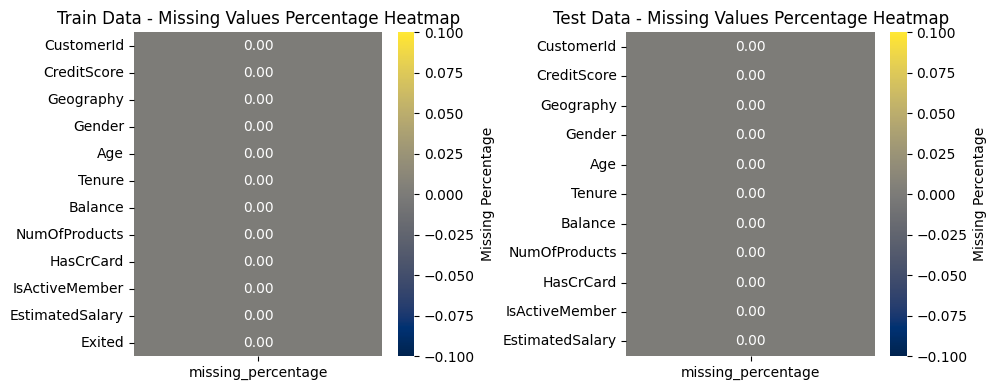

In [149]:
def plot_missing_values_heatmap(data, title, subplot_position):
    # Calculate the percentage of missing values for each column
    missing_percentage = data.isnull().mean() * 100

    # Create a DataFrame with missing percentage information
    missing_info = pd.DataFrame({'column': data.columns, 'missing_percentage': missing_percentage})

    # Create a heatmap grid highlighting missing values percentage
    plt.subplot(subplot_position)
    sns.heatmap(missing_info[['missing_percentage']], cmap='cividis', annot=True, fmt='.2f', cbar_kws={'label': 'Missing Percentage'})
    plt.title(f'{title} - Missing Values Percentage Heatmap')

# Create a single figure with one row and two columns
plt.figure(figsize=(10, 4))

# Plot missing values heatmap for the training data
plot_missing_values_heatmap(df_train, title='Train Data', subplot_position=121)

# Plot missing values heatmap for the test data
plot_missing_values_heatmap(df_test, title='Test Data', subplot_position=122)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# **5. Target Feature Analysis**

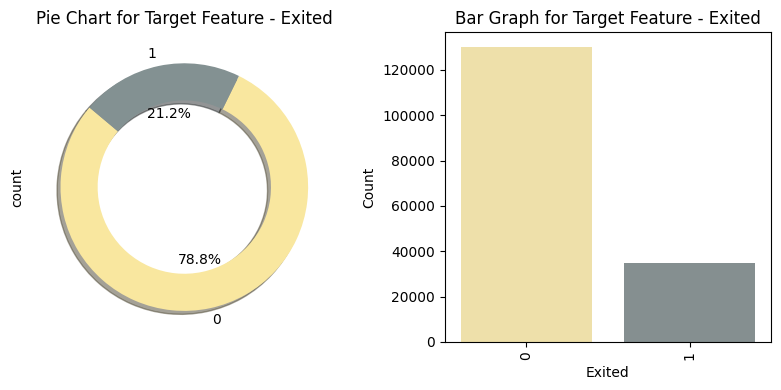

In [150]:
# Analysis of TARGET feature

# Define a custom color palette for categorical features
target_palette = ['#F9E79F', '#839192']

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Pie Chart
plt.subplot(1, 2, 1)
df_train[target].value_counts().plot.pie(autopct='%1.1f%%', colors=target_palette, wedgeprops=dict(width=0.3), startangle=140, ax=axes[0],shadow=True)
plt.title(f"Pie Chart for Target Feature - {target}")

# Bar Graph
plt.subplot(1, 2, 2)
sns.countplot(data=pd.concat([df_train]), x=target, palette=target_palette)
plt.ylabel("Count")
plt.title(f"Bar Graph for Target Feature - {target}")
plt.xticks(rotation=90)
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

# **6. Correlation Matrix**

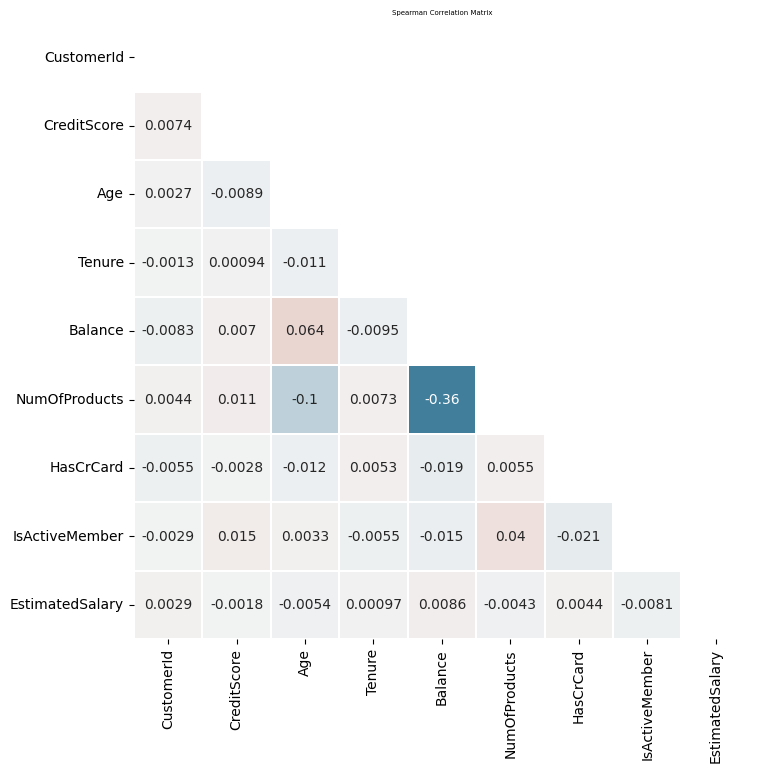

In [151]:
from matplotlib.colors import SymLogNorm

correlation_matrix = df_train[NUM_FEATS].corr()
f, ax = plt.subplots(figsize=(10, 8))
_ = sns.heatmap(
    correlation_matrix, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool)), 
    cmap=sns.diverging_palette(230, 20, as_cmap=True), 
    center=0,
    square=True, 
    linewidths=.1, 
    cbar=False,
    ax=ax,
    annot=True,
)
_ = ax.set_title("Spearman Correlation Matrix", fontsize=5)

In [ ]:
# # Find different levels in each column
# for column in df_train.columns:
#     unique_levels = df_train[column].unique()
#     print(f"Levels in {column}: {unique_levels}")

# 7. Categorical feature encoding

In [154]:
# Encode all the categorical features
df_train_cat_encode = df_train[CAT_FEATS]
df_test_cat_encode= df_test[CAT_FEATS]

# Dummify the train and test data
df_train_cat_encoded = pd.get_dummies(df_train_cat_encode, columns = CAT_FEATS, drop_first=True)
df_test_cat_encoded = pd.get_dummies(df_test_cat_encode, columns = CAT_FEATS, drop_first=True)

In [155]:
df_train_cat_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male
0,False,False,True
1,False,False,True
2,False,False,True
3,False,False,True
4,False,True,True


In [156]:
df_test_cat_encoded.head()

,Geography_Germany,Geography_Spain,Gender_Male
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,True
4,True,False,True


# 8. Numerical feature scaling

In [157]:
# Scale all the numerical features
df_train_num_scale = df_train[NUM_FEATS]
df_test_num_scale = df_test[NUM_FEATS]

from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
minmax_scaler = MinMaxScaler()

# Fit the scaler on the training data
minmax_scaler.fit(df_train_num_scale)

# Scale the training data
df_train_num_scaled = minmax_scaler.transform(df_train_num_scale)
df_train_num_scaled = pd.DataFrame(df_train_num_scaled, columns=df_train_num_scale.columns)

# Scale the test data using the parameters from the training data
df_test_num_scaled = minmax_scaler.transform(df_test_num_scale)
df_test_num_scaled = pd.DataFrame(df_test_num_scaled, columns=df_test_num_scale.columns)


In [158]:
# Concatenate datasets
df_train_combined = pd.concat([df_train_cat_encoded.reset_index(drop=True), df_train_num_scaled.reset_index(drop=True)], axis=1)

# Concatenate test datasets
df_test_combined = pd.concat([df_test_cat_encoded.reset_index(drop=True), df_test_num_scaled.reset_index(drop=True)], axis=1)

In [159]:
df_train_combined['Exited'] = df_train['Exited']

In [160]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df_train_combined.drop(columns=[target])
y = df_train_combined[target]

In [ ]:
# import imblearn
# from imblearn.over_sampling import SMOTE
# smote = SMOTE()
# X, y = smote.fit_resample(X, y)
# print("Before Smoote" , y.value_counts())
# print()
# print("After Smoote" , y_smote.value_counts())

# 9. Hyperparameter tuning

## 9.1 Tuning the XGBoost

[I 2024-02-15 16:50:28,019] A new study created in memory with name: no-name-75d18f94-2326-4a10-b251-e0ec514c57bd
[I 2024-02-15 16:50:46,080] Trial 0 finished with value: 0.8392883756349492 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'learning_rate': 0.7072955516200644, 'n_estimators': 920, 'subsample': 0.483394238468293, 'colsample_bytree': 0.7382866197593352, 'random_state': 42}. Best is trial 0 with value: 0.8392883756349492.
[I 2024-02-15 16:50:57,921] Trial 1 finished with value: 0.8487959186421714 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'learning_rate': 0.6201265198684189, 'n_estimators': 539, 'subsample': 0.718264301598049, 'colsample_bytree': 0.8031444100133944, 'random_state': 42}. Best is trial 1 with value: 0.8487959186421714.


Best hyperparameters: {'max_depth': 6, 'min_child_weight': 7, 'learning_rate': 0.6201265198684189, 'n_estimators': 539, 'subsample': 0.718264301598049, 'colsample_bytree': 0.8031444100133944, 'random_state': 42}
Best objective value (Mean Squared Error): 0.8487959186421714
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     26052
           1       0.65      0.55      0.59      6955

    accuracy                           0.84     33007
   macro avg       0.77      0.73      0.75     33007
weighted avg       0.83      0.84      0.84     33007



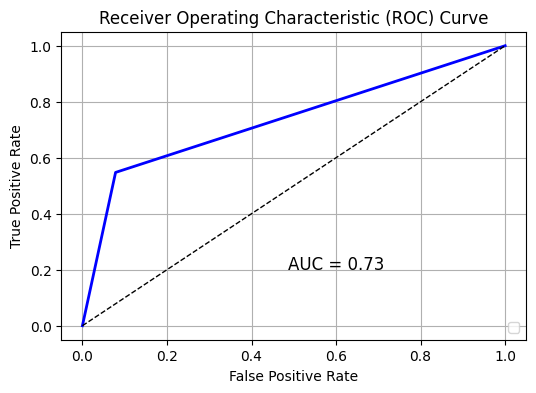

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
            'max_depth': trial.suggest_int('max_depth', 5, 10),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
            'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
            'subsample': trial.suggest_float('subsample', 0.01, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
            'random_state': trial.suggest_categorical('random_state', [42]),
            'tree_method': 'hist',  
            'device': 'cuda',
            'eval_metric': 'auc',  # Evaluation metric
            'verbosity': 0,  # Set verbosity to 0 for less output
        }

    # Create and train the model with the suggested hyperparameters
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and the corresponding objective value
print("Best hyperparameters:", study.best_params)
print("Best objective value (Mean Squared Error):", study.best_value)
xgb_params = study.best_params


best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.text(0.6, 0.2, 'AUC = %0.2f' % auc_score, fontsize=12, ha='center')
plt.show()

## 9.2 Tuning the Catboost

[I 2024-02-15 16:53:40,153] A new study created in memory with name: no-name-77bf9fdc-5472-4a66-8921-63da51a24ad0
[I 2024-02-15 16:53:48,120] Trial 0 finished with value: 0.8909838013515634 and parameters: {'iterations': 692, 'depth': 3, 'min_data_in_leaf': 16, 'learning_rate': 0.07365562356810598}. Best is trial 0 with value: 0.8909838013515634.
[I 2024-02-15 16:53:59,859] Trial 1 finished with value: 0.8875370533058751 and parameters: {'iterations': 986, 'depth': 3, 'min_data_in_leaf': 14, 'learning_rate': 0.006603951474249209}. Best is trial 0 with value: 0.8909838013515634.


Best hyperparameters: {'iterations': 692, 'depth': 3, 'min_data_in_leaf': 16, 'learning_rate': 0.07365562356810598}
0:	learn: 0.6356416	total: 11.4ms	remaining: 7.88s
1:	learn: 0.5902246	total: 22.8ms	remaining: 7.88s
2:	learn: 0.5538528	total: 36.2ms	remaining: 8.32s
3:	learn: 0.5233676	total: 47.6ms	remaining: 8.19s
4:	learn: 0.4981729	total: 58.8ms	remaining: 8.08s
5:	learn: 0.4754480	total: 71.2ms	remaining: 8.14s
6:	learn: 0.4591006	total: 82.3ms	remaining: 8.05s
7:	learn: 0.4453538	total: 96.2ms	remaining: 8.22s
8:	learn: 0.4344686	total: 109ms	remaining: 8.24s
9:	learn: 0.4225225	total: 120ms	remaining: 8.18s
10:	learn: 0.4137267	total: 132ms	remaining: 8.16s
11:	learn: 0.4042017	total: 143ms	remaining: 8.12s
12:	learn: 0.3983093	total: 155ms	remaining: 8.1s
13:	learn: 0.3918305	total: 166ms	remaining: 8.05s
14:	learn: 0.3866350	total: 178ms	remaining: 8.02s
15:	learn: 0.3813371	total: 189ms	remaining: 7.98s
16:	learn: 0.3779470	total: 200ms	remaining: 7.93s
17:	learn: 0.3736562

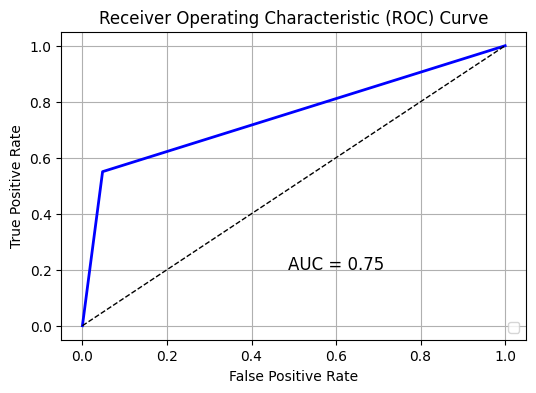

In [140]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'iterations': trial.suggest_int('iterations', 200, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.2, log=True),
        'random_state': 42,
        'verbose': 0,
        'eval_metric': 'AUC',
    }

    # Create and train the model with the suggested hyperparameters
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and the corresponding objective value
print("Best hyperparameters:", study.best_params)
cat_params = study.best_params


best_model = CatBoostClassifier(**cat_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.text(0.6, 0.2, 'AUC = %0.2f' % auc_score, fontsize=12, ha='center')
plt.show()

## 9.3 Tuning the LGBM

[I 2024-02-15 16:54:51,420] A new study created in memory with name: no-name-2f4a7d7c-1a08-4ff8-9289-b4a6def90861
[I 2024-02-15 16:54:59,137] Trial 0 finished with value: 0.8803001004571623 and parameters: {'max_depth': 9, 'min_child_samples': 4, 'learning_rate': 0.32101570714785266, 'n_estimators': 712, 'subsample': 0.28544566712285435, 'colsample_bytree': 0.4721331339146201, 'reg_alpha': 0.42166356227727764, 'reg_lambda': 0.6008551064202492}. Best is trial 0 with value: 0.8803001004571623.
[I 2024-02-15 16:55:06,036] Trial 1 finished with value: 0.88388899356626 and parameters: {'max_depth': 8, 'min_child_samples': 1, 'learning_rate': 0.27060258022942735, 'n_estimators': 526, 'subsample': 0.8903556580538039, 'colsample_bytree': 0.7663888060066603, 'reg_alpha': 0.6423450077396256, 'reg_lambda': 0.9385692858089205}. Best is trial 1 with value: 0.88388899356626.


Best hyperparameters: {'max_depth': 8, 'min_child_samples': 1, 'learning_rate': 0.27060258022942735, 'n_estimators': 526, 'subsample': 0.8903556580538039, 'colsample_bytree': 0.7663888060066603, 'reg_alpha': 0.6423450077396256, 'reg_lambda': 0.9385692858089205}
              precision    recall  f1-score   support

           0       0.89      0.94      0.92     26052
           1       0.73      0.56      0.64      6955

    accuracy                           0.86     33007
   macro avg       0.81      0.75      0.78     33007
weighted avg       0.86      0.86      0.86     33007



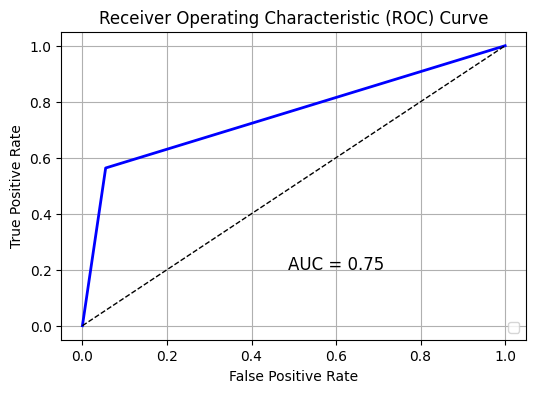

In [141]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 42,
    }

    # Create and train the model with the suggested hyperparameters
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    
    return auc

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

# Print the best hyperparameters and the corresponding objective value
print("Best hyperparameters:", study.best_params)
lgb_params = study.best_params


best_model = LGBMClassifier(**lgb_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))


fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.text(0.6, 0.2, 'AUC = %0.2f' % auc_score, fontsize=12, ha='center')
plt.show()

In [70]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def evaluate_model(model, X, y):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12)
    val_scores = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict_proba(X_val)[:, 1]

        val_score = roc_auc_score(y_val, y_pred)

        print(f"###### FOLD {fold + 1} ######")
        print(f"AUC Score: {val_score:.4f}")

        val_scores.append(val_score)

    mean_score = np.mean(val_scores)
    score_std = np.std(val_scores)
    return val_scores

# 10. Ensemble modelling

## 10.1 Voting classifier

In [73]:
from sklearn.ensemble import VotingClassifier

xgb_clf = XGBClassifier(**xgb_params)
lgb_clf = LGBMClassifier(**lgb_params)
cat_clf = CatBoostClassifier(**cat_params, verbose=False)

eclf = VotingClassifier(
    estimators=[("xgb", xgb_clf), ("lgb", lgb_clf), ("cat", cat_clf)],
    voting="soft"
)

val_scores.append(evaluate_model(eclf, X, y))

# y_test = df_test_combined.copy()

predictions = eclf.predict_proba(df_test_combined)[:, 1]

sub = pd.DataFrame({"id": df_submission['id'], 'Exited': predictions})
sub

###### FOLD 1 ######
AUC Score: 0.8857
###### FOLD 2 ######
AUC Score: 0.8887
###### FOLD 3 ######
AUC Score: 0.8897


              precision    recall  f1-score   support

           0       0.89      0.96      0.92     26052
           1       0.78      0.57      0.66      6955

    accuracy                           0.88     33007
   macro avg       0.84      0.76      0.79     33007
weighted avg       0.87      0.88      0.87     33007



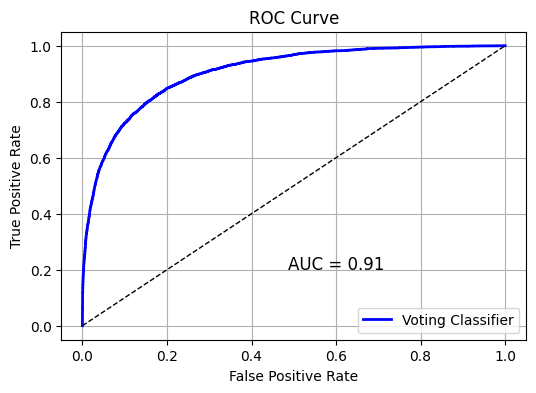

In [143]:
from sklearn.metrics import roc_curve, RocCurveDisplay, auc,classification_report
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

predictions = eclf.predict_proba(X_test)[:, 1]
predictions


y_pred = eclf.predict(X_test)
print(classification_report(y_test, y_pred))

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='Voting Classifier')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.text(0.6, 0.2, 'AUC = %0.2f' % roc_auc, fontsize=12, ha='center')
plt.show()

## 10.2 Average method

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a list of classifiers and their corresponding predictions
classifiers = [(xgb_clf, 'xgb'), (lgb_clf, 'lgb'), (cat_clf, 'cat')]

# Dictionary to store predictions
predictions = {}

# Loop through each classifier
for clf, name in classifiers:
    # Fit the classifier on the training data
    clf.fit(X_train, y_train)
    # Make predictions on the test data and store them in the predictions dictionary
    predictions[name] = clf.predict_proba(df_test_combined)[:, 1]

# Access the predictions for each classifier using its name
xgb_preds = predictions['xgb']
lgb_preds = predictions['lgb']
cat_preds = predictions['cat']

# Calculate average predictions
ensemble_pred = (xgb_preds + lgb_preds + cat_preds) / 3
ensemble_pred

sub = pd.DataFrame({"id": df_submission['id'], 'Exited': ensemble_pred})
sub


## 10.2 Weighed averaging

In [86]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

xgb_clf.fit(X_train, y_train, verbose=0)
lgb_clf.fit(X_train, y_train, verbose=0)
cat_clf.fit(X_train, y_train, verbose=0)

def objective(trial):
    xgb_weight = trial.suggest_uniform('xgb_weight', 0, 1)
    lgb_weight = trial.suggest_uniform('lgb_weight', 0, 1)
    cat_weight = trial.suggest_uniform('cat_weight', 0, 1)

    # Normalize weights to sum up to 1
    total_weight = xgb_weight + lgb_weight + cat_weight
    xgb_weight /= total_weight
    lgb_weight /= total_weight
    cat_weight /= total_weight

    # Ensemble predictions
    ensemble_pred_proba = (
        xgb_weight * xgb_clf.predict_proba(X_test)[:, 1] +
        lgb_weight * lgb_clf.predict_proba(X_test)[:, 1] +
        cat_weight * cat_clf.predict_proba(X_test)[:, 1]
    )

    # Assuming y_test is available
    auc_score = roc_auc_score(y_test, ensemble_pred_proba)

    return auc_score

# Optimize using Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Get the best weights
best_weights = study.best_params
best_weights

[I 2024-02-15 15:13:05,634] A new study created in memory with name: no-name-f3d623e4-708b-43d9-9970-958abd6bb253
[I 2024-02-15 15:13:06,437] Trial 0 finished with value: 0.8900644439905799 and parameters: {'xgb_weight': 0.06294651914259641, 'lgb_weight': 0.7612328504258076, 'cat_weight': 0.7097022689515223}. Best is trial 0 with value: 0.8900644439905799.
[I 2024-02-15 15:13:07,239] Trial 1 finished with value: 0.889693262674876 and parameters: {'xgb_weight': 0.14576068341865722, 'lgb_weight': 0.8979402301678157, 'cat_weight': 0.22706533320881128}. Best is trial 0 with value: 0.8900644439905799.
[I 2024-02-15 15:13:08,048] Trial 2 finished with value: 0.8891008401080704 and parameters: {'xgb_weight': 0.002019308229755379, 'lgb_weight': 0.32879368994736524, 'cat_weight': 0.955641756595485}. Best is trial 0 with value: 0.8900644439905799.
[I 2024-02-15 15:13:08,862] Trial 3 finished with value: 0.8869989189511924 and parameters: {'xgb_weight': 0.7485822841563222, 'lgb_weight': 0.2448472

{'xgb_weight': 0.06294651914259641,
 'lgb_weight': 0.7612328504258076,
 'cat_weight': 0.7097022689515223}

In [91]:
# Define a list of classifiers, their corresponding predictions, and weights
classifiers = [(xgb_preds, best_weights['xgb_weight']), 
               (lgb_preds, best_weights['lgb_weight']), 
               (cat_preds, best_weights['cat_weight'])]

# Calculate the weighted average of predicted probabilities
ensemble_pred_proba = sum(pred * weight for pred, weight in classifiers)

# Create a DataFrame for submission
ensemble_submission_df = pd.DataFrame({"id": df_submission['id'], 'Exited': ensemble_pred_proba})
ensemble_submission_df

,id,Exited
0,165034,0.039632
1,165035,1.234849
2,165036,0.047195
3,165037,0.370247
4,165038,0.552538
...,...,...
110018,275052,0.050414
110019,275053,0.182972
110020,275054,0.034206
110021,275055,0.222568
